In [223]:
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point

from karyotype import Karyotype
from utils.chromo_cv_utils import cv_imread, cv_imwrite
import banding_pattern_extraction as bpe

In [224]:
KYT_IMG_FP = r"D:/Prj/github/locate_centromere/tst/L2311306006.111.K.JPG"

In [225]:
kyt = Karyotype(KYT_IMG_FP)
kyt.read_karyotype()
len(kyt.chromo_cntr_dicts)
# 1. 每排的每个染色体轮廓都有染色体编号信息
# 2. 每排的每个染色体碎片轮廓都同其染色体主干轮廓合并了
# 3. 数据的排列格式是以cy为key的字典,每个cy对应的value是该cy行的所有的染色体轮廓信息
# return chromo_cntr_dicts_orgby_cy: {cy1:[{chromo_id:'1',chromo_idx:0,cx:100,cy:200,contour:[[x,y]]},...], cy2:[...], ...}
# and chromo_cntr_dicts: [{chromo_id:'1',chromo_idx:0,cx:100,cy:200,contour:[[x,y]]},{chromo_id:'1', ...}, ...]
# self.cntr_dicts[idx]["cntr_idx"] = idx
# self.cntr_dicts[idx]["cntr"] = contour
# self.cntr_dicts[idx]["area"] = cv2.contourArea(contour)
# self.cntr_dicts[idx]["rect"] = cv2.boundingRect(contour)
# # bc means bottom center
# self.cntr_dicts[idx]["bc_x"] = x + w // 2
# self.cntr_dicts[idx]["bc_y"] = y + h
# self.cntr_dicts[idx]["bc_point"] = (self.cntr_dicts[idx]["bc_x"], self.cntr_dicts[idx]["bc_y"])
# self.cntr_dicts[idx]["min_area_rect"] = cv2.minAreaRect(contour)
# self.cntr_dicts[idx]["cx"] = int(moments["m10"] / moments["m00"])
# self.cntr_dicts[idx]["cy"] = int(moments["m01"] / moments["m00"])
# self.cntr_dicts[idx]["center"] = (self.cntr_dicts[idx]["cx"], self.cntr_dicts[idx]["cy"])
# self.cntr_dicts[idx]["ori_cropped"] = ori_cropped  # bbox cropped from image
# self.cntr_dicts[idx]["gray_cropped"] = gray_cropped  # bbox cropped from image which grayed already
# self.cntr_dicts[idx]["wbg_cropped"] = wbg_cropped  # bbox cropped from img copy to white background
# self.cntr_dicts[idx]["cropped_cntr"] = contours

40

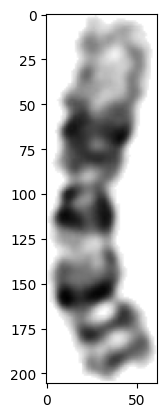

In [226]:
chromo_img = kyt.chromo_cntr_dicts[0]["wbg_cropped"]
# fig = plt.figure(dpi=400)  # 创建一个300 DPI的图像窗口
# fig.add_subplot(111)
plt.imshow(chromo_img, cmap='gray')
plt.show()

In [227]:
chromo_img.shape
chromo_gray = cv2.cvtColor(chromo_img, cv2.COLOR_BGR2GRAY) if chromo_img.ndim == 3 else chromo_img
chromo_bgr = cv2.cvtColor(chromo_gray, cv2.COLOR_GRAY2BGR) if chromo_img.ndim == 2 else chromo_img

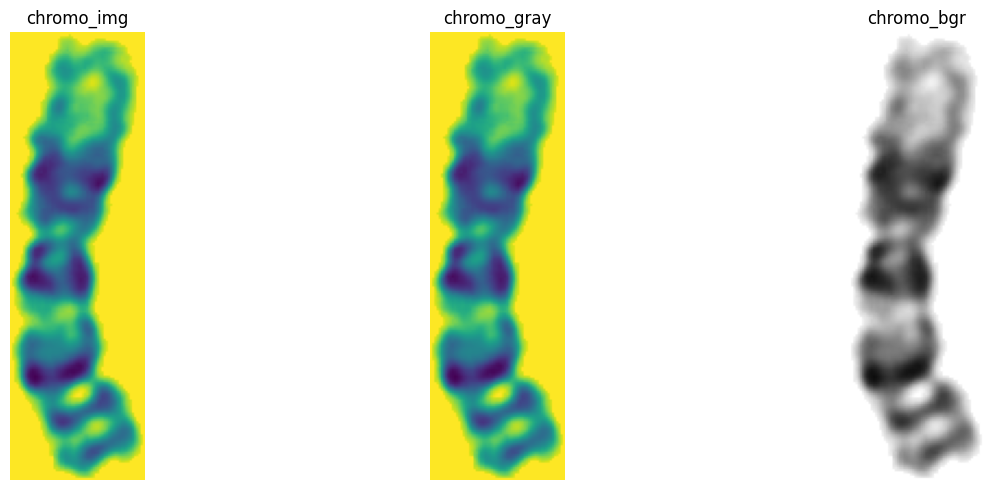

In [228]:
# 创建一个图形，调整子图布局
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1行3列，设置图形大小

# 显示每张图片
axes[0].imshow(chromo_img)
axes[0].set_title("chromo_img")
axes[0].axis("off")  # 隐藏坐标轴

# axes[1].imshow(chromo_gray, cmap='gray')
axes[1].imshow(chromo_gray)
axes[1].set_title("chromo_gray")
axes[1].axis("off")  # 隐藏坐标轴

axes[2].imshow(chromo_bgr)
axes[2].set_title("chromo_bgr")
axes[2].axis("off")  # 隐藏坐标轴

# 显示图形
plt.tight_layout()
plt.show()

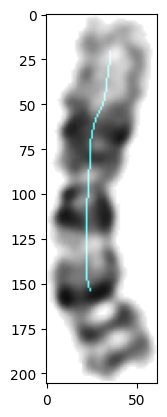

In [229]:
# get skeleton
result = bpe.get_banding_pattern(chromo_gray,pixel_sampling=5,chromosome_threshold=253)
chromo_gray_size = chromo_gray.shape[:2]
skeleton = np.full(shape=chromo_gray_size, fill_value=0, dtype=np.uint8)
r = result['r_sampled'] # r means row -> X
c = result['c_sampled'] # c means column -> Y
skeleton_points = [(int(x), int(y)) for x, y in zip(c, r)]
# 去重
skeleton_points = list(set(skeleton_points))
# 按y坐标排序
skeleton_points.sort(key=lambda x: x[1])
# 掐头去尾
h, w = chromo_gray_size
head_limit = 0.1 * h
tail_limit = h - (0.25 * h)
# final skeleton points
skeleton_points = [coord for coord in skeleton_points if head_limit < coord[1] < tail_limit]

# draw skeleton
r = [coord[1] for coord in skeleton_points]
c = [coord[0] for coord in skeleton_points]
for i in range(len(r)):
    skeleton[int(r[i])][int(c[i])] = 255
skeleton = np.stack((skeleton, skeleton, skeleton), axis=2)
skeleton[:, :, 0] = 0
skeleton[:, :, 1][skeleton[:, :, 1] != 0] = 200
skeleton[:, :, 2][skeleton[:, :, 2] != 0] = 200
chromo_skeleton = cv2.add(chromo_bgr, skeleton)
plt.imshow(chromo_skeleton)
plt.show()

In [230]:
from shapely.geometry import LineString, MultiPoint, Point

def calculate_normals_and_intersections(contour, skeleton_points, size, point_interval=1, line_length=1000):
    """
    逐点计算骨架点的垂线方向，与轮廓的交点、距离以及中点。

    参数:
    - contour: 轮廓点集合，形状为 (N, 2)
    - skeleton_points: 骨架点集合，形状为 (M, 2)
    - point_interval: 前后点的间隔，默认为 1

    返回:
    - results: 包含每个骨架点的结果，包括交点、距离和中点
    """
    # 检查 contour 是否有效
    # contour = np.unique(contour, axis=0)  # 去掉重复点
    # if len(contour) < 2:
    #     raise ValueError("Contour must contain at least 2 unique points to create a valid LineString.")

    # 转换轮廓为 Shapely 的 LineString
    # contour_line = LineString(contour)
    contour_line = LineString(contour[:, 0, :])

    results = []

    for i in range(len(skeleton_points)):
        # 当前骨架点
        x2, y2 = skeleton_points[i]

        # 处理骨架的前后点，允许点间隔可调
        if i - point_interval < 0:  # 如果前点越界，使用当前点代替
            x1, y1 = x2, y2
        else:
            x1, y1 = skeleton_points[i - point_interval]

        if i + point_interval >= len(skeleton_points):  # 如果后点越界，使用当前点代替
            x3, y3 = x2, y2
        else:
            x3, y3 = skeleton_points[i + point_interval]

        # 计算切线方向 dx, dy
        dx = (x3 - x1) / 2.0
        dy = (y3 - y1) / 2.0

        # 垂线方向 -dy, dx
        normal_dx = -dy
        normal_dy = dx

        # 定义垂线 (无限延长)
        line_start = (x2 - normal_dx * line_length, y2 - normal_dy * line_length)
        line_end = (x2 + normal_dx * line_length, y2 + normal_dy * line_length)
        normal_line = LineString([line_start, line_end])

        # 求垂线与轮廓的交点
        intersections = contour_line.intersection(normal_line)

        # # 画轮廓
        # contour_bit_img = np.zeros(size, dtype=np.uint8)
        # cv2.drawContours(contour_bit_img, [contour], -1, 255, thickness=1)
        # cv_imwrite("contour_bit_img.jpg", contour_bit_img)
        # # 画垂线
        # vline_bit_img = np.zeros(size, dtype=np.uint8)
        # cv2.line(vline_bit_img, (int(line_start[0]), int(line_start[1])), (int(line_end[0]), int(line_end[1])), 255, 1)
        # cv_imwrite("vline_bit_img.jpg", vline_bit_img)
        # # 寻找交点：通过二值图像的交集
        # intersections = cv2.bitwise_and(contour_bit_img, vline_bit_img)
        # cv_imwrite("intersections.jpg", intersections)
        # # 提取交点坐标
        # # coords = np.column_stack(np.where(intersections > 0))
        # coords = cv2.findNonZero(intersections)
        # print(coords)

        # 处理交点
        intersection_coords = []
        if isinstance(intersections, Point):
            intersection_coords = [intersections.coords[0]]
        elif isinstance(intersections, MultiPoint):
            intersection_coords = [point.coords[0] for point in intersections.geoms]
        elif isinstance(intersections, LineString):
            # 如果交点是线段，取线段的两个端点
            intersection_coords = [intersections.coords[0], intersections.coords[-1]]

        # 取最近的两个交点
        if len(intersection_coords) >= 2:
            # 按距离排序，找到最近的两个交点
            p1, p2 = sorted(intersection_coords, key=lambda p: np.linalg.norm(np.array(p) - np.array([x2, y2])))[:2]

            # 计算交点间的距离
            distance = np.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)

            # 计算中点
            midpoint = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

            # 保存结果
            results.append({
                "skeleton_point": (x2, y2),
                "intersection_points": (p1, p2),
                "distance": distance,
                "midpoint": midpoint
            })

    return results

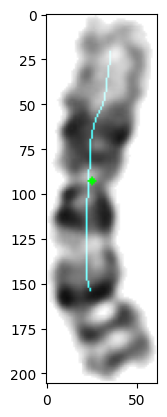

In [231]:
contour = kyt.chromo_cntr_dicts[0]["cropped_cntr"][0]
skeleton_points = np.array(skeleton_points)
ll = int(math.sqrt(h**2 + w**2))
vline_results = calculate_normals_and_intersections(contour, skeleton_points, (h, w), 5, ll)

# 画出结果
chromo_skeleton_cp = chromo_skeleton.copy()
# for v_line in vline_results:
#     x1, y1 = v_line["intersection_points"][0]
#     x2, y2 = v_line["intersection_points"][1]
#     cv2.line(chromo_skeleton_cp, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 1)  # Red
#     # cv2.circle(chromo_skeleton_cp, (int(x1), int(y1)), 2, (255, 0, 0), -1)  # Blue
#     # cv2.circle(chromo_skeleton_cp, (int(x2), int(y2)), 2, (255, 0, 0), -1)  # Blue

centromere_point = min(vline_results, key=lambda x: x["distance"])["midpoint"]
centromere_point = (int(centromere_point[0]), int(centromere_point[1]))
cv2.circle(chromo_skeleton_cp, centromere_point, 2, (0, 255, 0), -1)  # Green
plt.imshow(chromo_skeleton_cp)
plt.show()
cv_imwrite("chromo_skeleton_cp.jpg", chromo_skeleton_cp)

In [232]:
def line_equation(p1, p2, x):
    """计算直线方程 y = kx + b"""
    if p2[0] - p1[0] != 0:  # 避免除以零
        k = (p2[1] - p1[1]) / (p2[0] - p1[0])
        b = p1[1] - k * p1[0]
        return k * x + b
    else:  # 垂直线情况
        return None

def find_intersection_points_on_contour(contour, p1, p2):
    """计算直线与轮廓的交点"""
    intersection_points = []
    contour_points = contour.squeeze()
    for point in contour_points:
        x, y = point
        y_line = line_equation(p1, p2, x)
        if y_line is not None:
            if abs(y - y_line) <= 1:
                intersection_points.append((x, y))
    return intersection_points

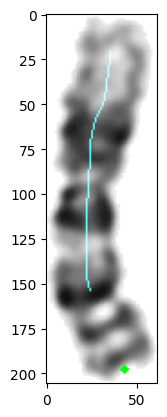

In [233]:
# do vertical line on skeleton
pstarts, pends = result['pstart'], result['pend']  # 垂线的起点和终点
chromo_skeleton_vline = chromo_skeleton.copy()
contour = kyt.chromo_cntr_dicts[0]["cropped_cntr"][0]
# cv2.drawContours(chromo_skeleton_vline, [contour], -1, (0, 0, 255), 1) # Red
min_distance = 100000
min_distance_mid_point = (0, 0)
h, w = chromo_gray_size
for i in range(len(pends)):
    p1 = (int(pstarts[i][1]), int(pstarts[i][0]))
    p2 = (int(pends[i][1]), int(pends[i][0]))
    intersection_points = find_intersection_points_on_contour(contour, p1, p2)
    # 如果交点大于2个，则进行二聚类，求聚类中心点的距离和连线的中点
    if len(intersection_points) > 2:
        intersection_points = np.array(intersection_points)
        # 二聚类
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=2, random_state=0).fit(intersection_points)
        cluster_centers = kmeans.cluster_centers_
        p1 = np.array(tuple(map(int, cluster_centers[0])))
        p2 = np.array(tuple(map(int, cluster_centers[1])))
    elif len(intersection_points) == 2:
        p1 = np.array(intersection_points[0])
        p2 = np.array(intersection_points[1])
    else:
        continue
    mid_point = (p1 + p2) // 2
    distance = np.linalg.norm(p1 - p2)
    if 3 < distance < min_distance:
        min_distance = distance
        min_distance_mid_point = mid_point

cv2.circle(chromo_skeleton_vline, min_distance_mid_point, 2, (0, 255, 0), -1)  # Green

plt.imshow(chromo_skeleton_vline)
plt.show()
cv_imwrite("chromo_skeleton_vline.jpg", chromo_skeleton_vline)

In [234]:
len(kyt.chromo_cntr_dicts[0]["cropped_cntr"][0].squeeze()), kyt.chromo_cntr_dicts[0]["cropped_cntr"][0].squeeze()

(227,
 array([[ 27,   1],
        [ 26,   2],
        [ 23,   2],
        [ 22,   3],
        [ 22,   7],
        [ 19,  10],
        [ 18,  10],
        [ 18,  13],
        [ 16,  15],
        [ 16,  21],
        [ 17,  22],
        [ 17,  24],
        [ 18,  25],
        [ 17,  26],
        [ 17,  27],
        [ 16,  28],
        [ 16,  30],
        [ 14,  32],
        [ 14,  38],
        [ 13,  39],
        [ 12,  39],
        [ 12,  40],
        [  8,  44],
        [  8,  46],
        [  6,  48],
        [  7,  49],
        [  7,  51],
        [  8,  52],
        [  8,  53],
        [  9,  54],
        [  9,  56],
        [  8,  57],
        [  8,  59],
        [  6,  61],
        [  6,  64],
        [  5,  65],
        [  5,  66],
        [  6,  67],
        [  6,  77],
        [  5,  78],
        [  5,  80],
        [  4,  81],
        [  4,  82],
        [  3,  83],
        [  4,  84],
        [  4,  85],
        [  5,  86],
        [  5,  87],
        [  6,  88],
        [  7, 

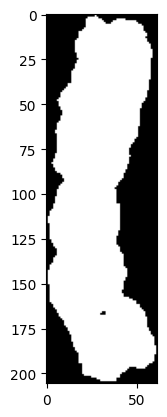

In [235]:
chromo_gray_bin = cv2.threshold(chromo_gray, 253, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(chromo_gray_bin, cmap='gray')
plt.show()

In [236]:
contours, _ = cv2.findContours(chromo_gray_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
len(contours[0].squeeze()) #, contours[0].squeeze()

227